<a href="https://colab.research.google.com/github/ShangWeiKuo/Portfolio/blob/main/Python/Classification/Multiclass/Wafer/Wafer_classification_Densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 讀取 libraries
import numpy as np 
from numpy import argmax
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 

from keras.utils.np_utils import to_categorical
from keras import layers, Input, models
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import DenseNet201
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import cv2
from skimage import measure
from scipy import stats

import os
# 設定當前工作目錄
path="/content/drive/MyDrive/wafer/"
os.chdir(path)

print(os.listdir(path))

import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl', 'wafer.zip', 'Untitled1.ipynb', 'wafer-defect-classification-by-deep-learning.ipynb', 'Wafer detection.ipynb', 'Wafer anomaly detection.ipynb', 'Wafer classification_KFold.ipynb', 'Wafer anomaly detection_Denoising AutoEncoder.ipynb', 'Wafer anomaly detection_AutoEncoder.ipynb', 'wafer_detection_densenet_model.h5', 'Wafer classification_Densenet201.ipynb']


In [2]:
# 讀取資料(pkl檔)
df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
# 刪除原先的index
df = df.drop(['waferIndex'], axis = 1)

In [4]:
# 算出晶圓的長寬，並儲存至新欄位 waferMapDim
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0,dim1
df['waferMapDim'] = df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
414292,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2071.0,lot24635,[[Training]],[[Edge-Loc]],"(52, 51)"
223190,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot14058,[],[],"(44, 44)"
129303,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5082.0,lot8473,[],[],"(87, 74)"
600741,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot37764,[],[],"(49, 39)"
509849,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",515.0,lot31808,[],[],"(25, 27)"


In [5]:
# 將 failureType 和 trianTestLabel 欄位名稱改為 failureNum 和 trainTestNum 
df['failureNum'] = df.failureType
df['trainTestNum'] = df.trianTestLabel
# 將 failureNum 和 trainTestNum 兩個欄位內容轉為數字代碼
mapping_type = {'Center':0,
         'Donut':1,
         'Edge-Loc':2,
         'Edge-Ring':3,
         'Loc':4,
         'Random':5,
         'Scratch':6,
         'Near-full':7,
         'none':8} # none = 無缺陷
mapping_traintest = {'Training':0, 'Test':1}
df = df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [6]:
# 從原始資料取出 8 種缺陷類型的晶圓資料
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
# 重設 index
df_withpattern = df_withpattern.reset_index()
# 刪除後續沒有用到的欄位 dieSize 和 lotName
df_withpattern = df_withpattern.drop(columns=['dieSize', 'lotName'])

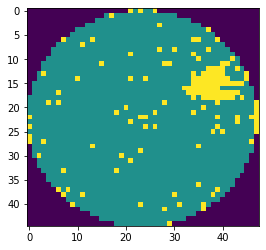

In [7]:
# 第一張晶圓缺陷圖呈現(缺陷種類: Loc)
plt.imshow(df_withpattern.waferMap[0])
plt.show()

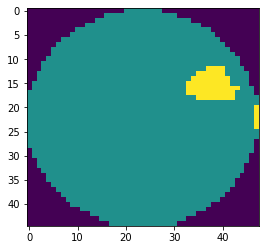

In [8]:
# 經過中值濾波器(median filter)降噪後的第一張晶圓缺陷圖呈現
plt.imshow(cv2.medianBlur(df_withpattern.waferMap[0], 3))
plt.show()

In [9]:
# 將資料複製一份到新變數 df_labeled
df_labeled = df_withpattern.copy()
# 取出晶圓陣列資料
X = df_labeled['waferMap'].values
# 取出缺陷種類欄位的內容，並轉換為 float 32 位元型態，接著利用 to_categorical 將類別向量 y 轉換為二進位的矩陣向量(One-hot encoding 技術，以 0 和 1 區分標籤類別)
y = np.array(df_labeled['failureNum']).astype('float32') # astype 適用於 numpy 中資料型態的轉換
y = to_categorical(y, num_classes=8)

In [10]:
# 將每張圖片利用中值濾波器去除影像雜訊，並存到 X_copy
X_copy = [ ]

for i in range(X.shape[0]):
  img = cv2.medianBlur(X[i], 3)
  X_copy.append(img)

X_copy = np.array(X_copy)

In [11]:
# 將每張圖片大小設定為 64 x 64
X_copy_v2 = np.array([cv2.resize(img, dsize=(64,64)) for img in X_copy])

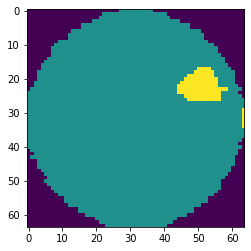

In [12]:
# 降噪後的晶圓缺陷圖 (種類:Loc, 大小: 64 x 64)
plt.imshow(X_copy_v2[0])
plt.show()

In [13]:
# 每張圖片轉換為三維空間大小 
# (注意: 第三維的數值為 1，目前還不能填 3，否則會因為無法從原先 64 x 64 的維度拆解為 64 x 64 x 3而出現 error)
X_copy_v2 = X_copy_v2.reshape((-1, 64, 64, 1))

In [14]:
# 根據 Data Science & Business Analytics Lab, School of Industrial Management Engineering, College of Engineering, Korea University[http://dsba.korea.ac.kr/main] 的方法
# Wafer data's each pixels have a categorical variable that express 0 : not wafer, 1 : normal, 2 : faulty.
# Extend extra dimension with one-hot-encoded categorical data as channel.
new_X_copy = np.zeros((len(X_copy_v2), 64, 64, 3))

for w in range(len(X_copy_v2)):
  for i in range(64):
    for j in range(64):
      new_X_copy[w, i, j, int(X_copy_v2[w, i, j])] = 1

In [15]:
# 轉換為 float 32 位元型態
new_X_copy = new_X_copy.astype('float32')

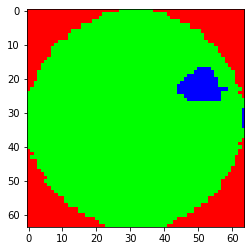

In [16]:
plt.imshow(new_X_copy[0])
plt.show()

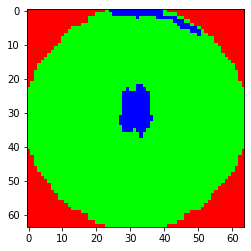

In [17]:
plt.imshow(new_X_copy[df_labeled['failureNum']==0][0])
plt.show()

In [18]:
# 資料切割 (80% = Train, 20% = Test)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X_copy, y, test_size=0.2, random_state=2021)

In [19]:
# 模型架構 (Densenet201)
def build_densenet():
    densenet = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(64, 64, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(8, activation = 'softmax')(x)
 
    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [20]:
# 呼叫模型
model = build_densenet()
# EarlyStopping：可設定訓練提早結束的條件。
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=10)
# ReduceLROnPlateau：當訓練已無改善時，可以降低學習率，追求更細微的改善，找到更精準的最佳解。
Reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# ModelCheckpoint：由於訓練過程耗時，有可能訓練一半就當掉，因此，我們可以利用這個 Callback，在每一個檢查點(Checkpoint)存檔，下次執行時，就可以從中斷點繼續訓練。
checkpoint = ModelCheckpoint('wafer_detection_densenet_model.h5', verbose=1, save_best_only=True)

# 訓練資料
History = model.fit(new_X_train, new_y_train, 
           epochs=100, 
           batch_size=64,
           verbose=2,
           callbacks=[Reduce, es, checkpoint],
           validation_split=0.2, # 訓練前將 Train data 分割 20% 作為 Validation data
           workers=8)

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
______________________________________________________________

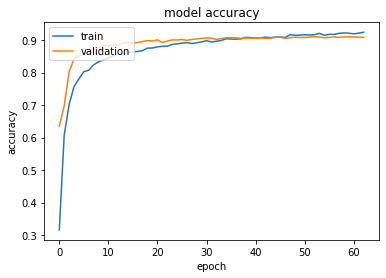

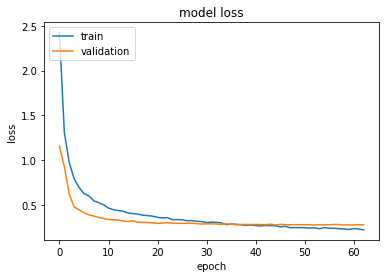

In [21]:
# Accuracy plot 
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
# Evaluation
score = model.evaluate(new_X_test, new_y_test)
print('Test Accuracy:', score[1])

160/160 [==============================] - 16s 86ms/step - loss: 0.2821 - accuracy: 0.9052
Test Accuracy: 0.9051724076271057


In [23]:
# 預測 Test data
predictions = model.predict(new_X_test)
predictions = np.argmax(predictions, axis=1)

In [24]:
# 取出真實值類別
true = np.argmax(new_y_test, axis=1)

In [25]:
# 混淆矩陣 (Confusion Matrix)
print(classification_report(true, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       831
           1       0.82      0.90      0.86       110
           2       0.85      0.88      0.86      1083
           3       0.97      0.98      0.97      1924
           4       0.83      0.77      0.80       718
           5       0.91      0.84      0.87       171
           6       0.78      0.67      0.72       234
           7       0.88      0.85      0.86        33

    accuracy                           0.91      5104
   macro avg       0.87      0.86      0.86      5104
weighted avg       0.90      0.91      0.90      5104



In [26]:
# 將預測值轉換為二進位的矩陣向量
onehot_encoder = OneHotEncoder(sparse=False)
predictions = predictions.reshape(len(predictions), 1)
predictions = onehot_encoder.fit_transform(predictions)

In [27]:
# 同上
onehot_encoder = OneHotEncoder(sparse=False)
true = true.reshape(len(true), 1)
true = onehot_encoder.fit_transform(true)

In [28]:
# 計算 AUC 值
test_auc = roc_auc_score(true, predictions)

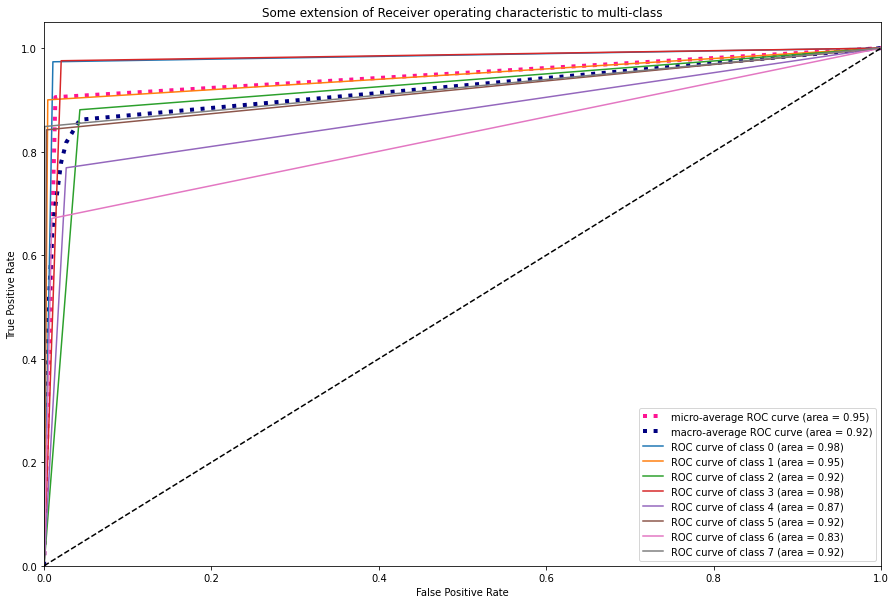

In [29]:
# ROC 圖
n_classes = 8

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(true[:, i], predictions[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(true.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(15, 10))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(n_classes):
  plt.plot(fpr[i], tpr[i],
      label='ROC curve of class {0} (area = {1:0.2f})'
      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()